# Forward encoding model based on Pim Mostert Decoding toolbox



In [1]:
!pwd

/Users/junjieji/Documents/GitHub/master-thesis


In [2]:
import sys
import time as tic
# %matplotlib qt
from scipy.io import loadmat
import numpy as np
import pandas as pd
import mat73

import inspect #path_fun = inspect.getfile(StratifiedKFold)
import matplotlib.pyplot as plt
import mne
import os
import random

from statsmodels.tsa.stattools import coint


# Variables

In [7]:
''' VARIABLES '''

dataset = 'eeg'

amount_of_subjects = 1 # Change the range so the process is faster
if amount_of_subjects > 26: amount_of_subjects = 26
subjs_list = ['s{:02d}'.format(i) for i in range(1, amount_of_subjects+1) if i != 6 ] 
nSubj = len(subjs_list)

numC = 8

angles = [i * 180./numC for i in range(numC)]

x_labels = np.array(angles)

resample = True # speeds up the procees but showing worse results overall
if resample: resample_frequency = 20 # in Hz, original freq is 500Hz

cfg_stim = dict()
cfg_stim['kappa'] = 4
cfg_stim['NumC'] = numC
cfg_stim['Tuning'] = 'vonmises'
# cfg_stim['Tuning'] = 'halfRectCos'
cfg_stim['offset'] = 0

cfg_train = dict()
cfg_train['gamma'] = 0.1
cfg_train['demean'] = True
cfg_train['returnPattern'] = True

cfg_test = dict()
cfg_test['demean'] = 'traindata'

# Loading & preparing orientation data

In [10]:
'''EEG Dataset'''
def read_data(number_of_repetition,
              resample,
              resample_frequency,
              subjs_list = subjs_list
              ):
    path = 'Cond_CJ_EEG'

    all_st_epochs = []
    all_st_rawdata = []
    for subject_id in subjs_list:
        preproc_path = os.path.join(path, subject_id)
        
        st_epoch = mne.read_epochs(os.path.join(preproc_path, 'mainstim_epo.fif'), verbose=False)
        # print(st_epoch.info['sfreq'])
        if resample: 
            print('Frequency before:', st_epoch.info['sfreq'])
            st_epoch = st_epoch.resample(resample_frequency)
            print('Frequency after:' ,st_epoch.info['sfreq'])
            
        all_st_epochs.append(st_epoch)
        all_st_rawdata.append(
            {
            'epoch_dat': st_epoch.get_data()[st_epoch.metadata['nrep'] == number_of_repetition,:,:] ,
            'metadata': st_epoch.metadata[st_epoch.metadata['nrep'] == number_of_repetition]
            }
            )
    return all_st_rawdata


# Procedure for multisubject

In [13]:
from decoding_toolbox_py.Helper_funcs.DecToolbox import CreateFolds, CV_encoder
from decoding_toolbox_py.Helper_funcs import DecToolbox as dt
def train(all_st_rawdata, raw_predicts = False):
    nSubj = len(all_st_rawdata)
    preds = [None] * nSubj
    G = [None] * nSubj

    for subj in range(nSubj):
        Y = all_st_rawdata[subj]['epoch_dat']
        Y = np.einsum('kji->jik', Y)
        print(Y.shape)
        Y = np.delete(Y, 25, axis=0)

        X = np.array(all_st_rawdata[subj]['metadata'].orient)
        X = np.digitize(X, bins = np.array(angles))-1.
        phi = X * (180./numC)
        numF, numT, numN = Y.shape

        G[subj] = X.copy() 
        
        CONDS = np.unique(G[subj])
        nConds = CONDS.size
        nfold = 5
        FoldsIdx = CreateFolds(G[subj], Y, nfold)
        
        design, sortedesign = dt.stim_features(phi, cfg_stim)
        
        Xhat = np.zeros([numC,numN, numT])
        for it in range(numT):
            cfg = dict()
            cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
            cfg['cfgD'] = {'demean' : 'traindata'}
            Xhat[:,:,it] = CV_encoder(design, Y, it, cfg, FoldsIdx)
        preds[subj] = Xhat
        print('preds', np.shape(preds[0]))
    if raw_predicts:
        return preds
        
    else:
        m_centered = np.zeros((numC,numC, numT, nSubj))
        for ival, isubj in enumerate(subjs_list):
            Xhat = preds[ival]
            Xhat_centered = 0*Xhat.copy()
            
            for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
                Xhat_centered[:, G[ival] == ic,:] = np.roll(Xhat[:,G[ival] == ic,:], -ic, axis = 0)
                m_centered[:,ic, :, ival] =  np.mean( Xhat_centered[:,  G[ival] == ic, :], axis = 1)

        Xhat_centeredmean = np.mean( m_centered, axis = 1)
        Xhat_centeredmean = np.mean( Xhat_centeredmean, axis = 2)
        print('Xhat_centeredmean', np.shape(Xhat_centeredmean))
        return Xhat_centeredmean

In [14]:
'''5 min 20hz'''

all_st_rawdata_rep = [None]*3
Xhat_centeredmean_rep = [None]*3

for i in range(3):
    print(i)
    all_st_rawdata_rep[i] = read_data(number_of_repetition=i, resample=False, resample_frequency=20)
    Xhat_centeredmean_rep[i] = train(all_st_rawdata_rep[i])

0
(32, 201, 518)
preds (8, 518, 201)
Xhat_centeredmean (8, 201)
1
(32, 201, 524)
preds (8, 524, 201)
Xhat_centeredmean (8, 201)
2
(32, 201, 521)
preds (8, 521, 201)
Xhat_centeredmean (8, 201)


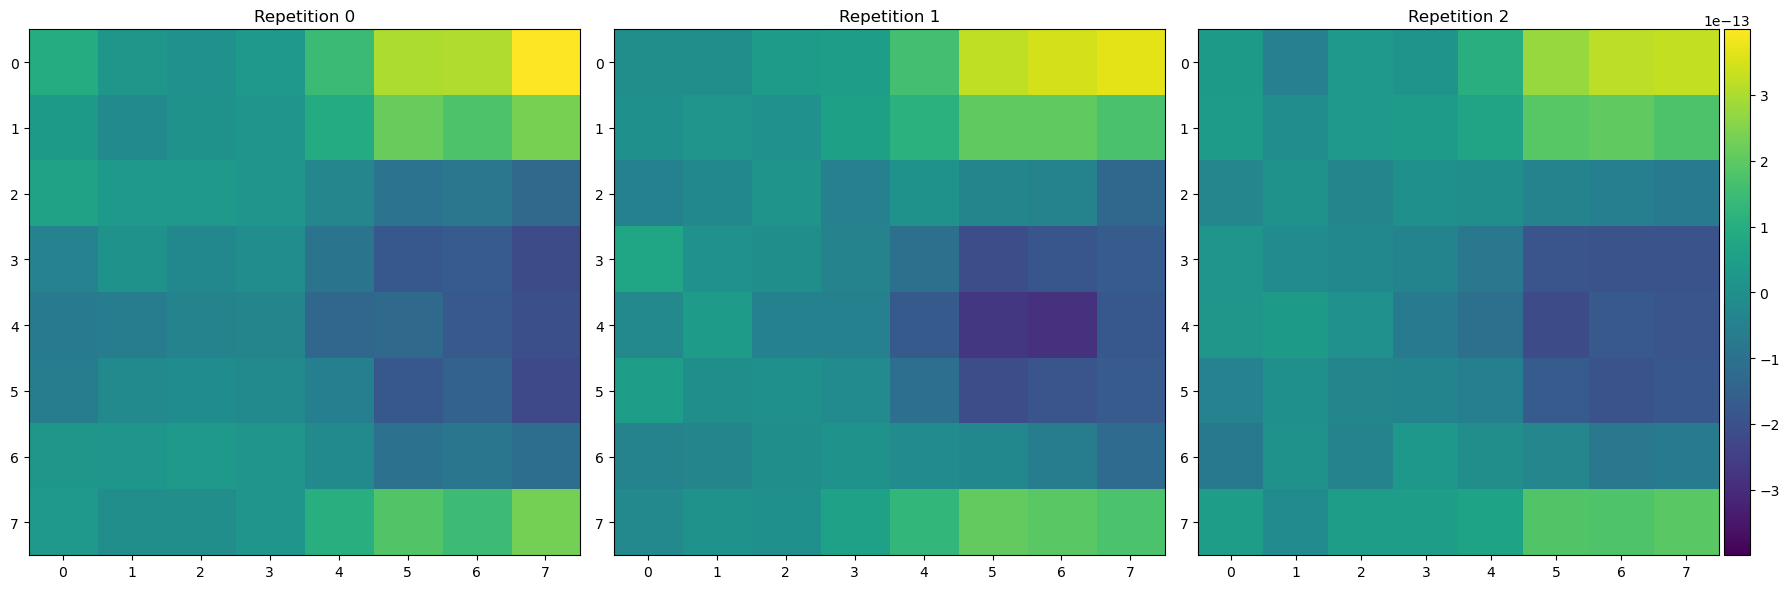

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

max_abs = np.max(np.abs(Xhat_centeredmean_rep))

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

im0 = axes[0].imshow(Xhat_centeredmean_rep[0], aspect='auto', vmin=-max_abs, vmax=max_abs)
axes[0].set_title('Repetition 0')

im1 = axes[1].imshow(Xhat_centeredmean_rep[1], aspect='auto', vmin=-max_abs, vmax=max_abs)
axes[1].set_title('Repetition 1')

im2 = axes[2].imshow(Xhat_centeredmean_rep[2], aspect='auto', vmin=-max_abs, vmax=max_abs)
axes[2].set_title('Repetition 2')

divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax)

plt.tight_layout()
plt.show()



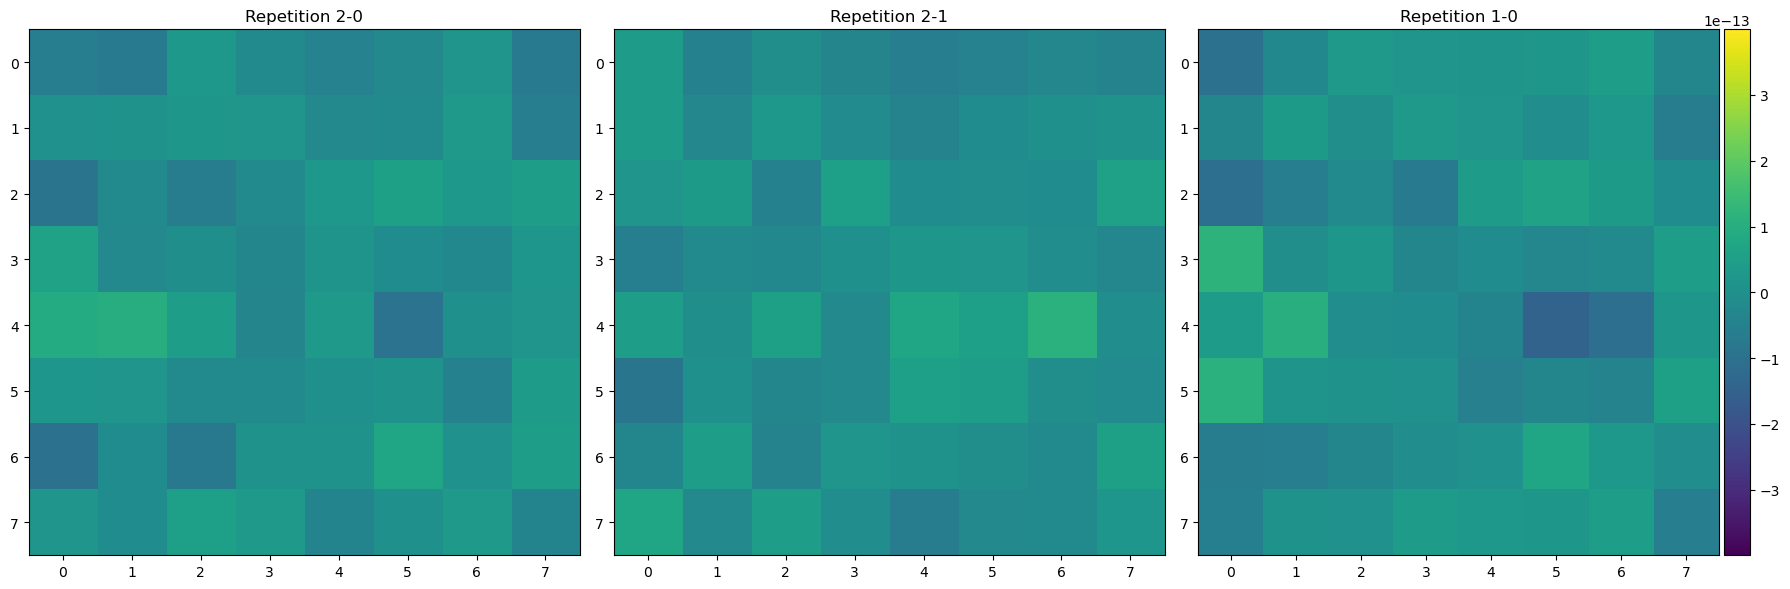

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

im0 = axes[0].imshow(Xhat_centeredmean_rep[2] - Xhat_centeredmean_rep[0], aspect='auto', vmin=-max_abs, vmax=max_abs)
axes[0].set_title('Repetition 2-0')

im1 = axes[1].imshow(Xhat_centeredmean_rep[2] - Xhat_centeredmean_rep[1], aspect='auto', vmin=-max_abs, vmax=max_abs)
axes[1].set_title('Repetition 2-1')

im2 = axes[2].imshow(Xhat_centeredmean_rep[1] - Xhat_centeredmean_rep[0], aspect='auto', vmin=-max_abs, vmax=max_abs)
axes[2].set_title('Repetition 1-0')

divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax)

plt.tight_layout()
plt.show()


In [ ]:
stophere

NameError: name 'stophere' is not defined



'''

Cluster based simulation, buscarlo en mne

'''


https://en.wikipedia.org/wiki/Pearson_correlation_coefficient
